# Ungraded Lab: Decision Trees

In this notebook you will visualize how a decision tree is splitted using information gain.

We will revisit the dataset used in the video lectures. The dataset is:

As you saw in the lectures, in a decision tree, we decide if a node will be split or not by looking at the **information gain** that split would give us. (Image of video IG)

Where 

$$\text{Information Gain} = H(p_1^\text{node})- \left(w^{\text{left}}H\left(p_1^\text{left}\right) + w^{\text{right}}H\left(p_1^\text{right}\right)\right),$$

and $H$ is the entropy, defined as

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$

Remember that log here is defined to be in base 2. Run the code block below to see by yourself how the entropy. $H(p)$ behaves while $p$ varies.

Note that the H attains its higher value when $p = 0.5$. This means that the probability of event is $0.5$. And its minimum value is attained in $p = 0$ and $p = 1$, i.e., the probability of the event happening is totally predictable. Thus, the entropy shows the degree of predictability of an event.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

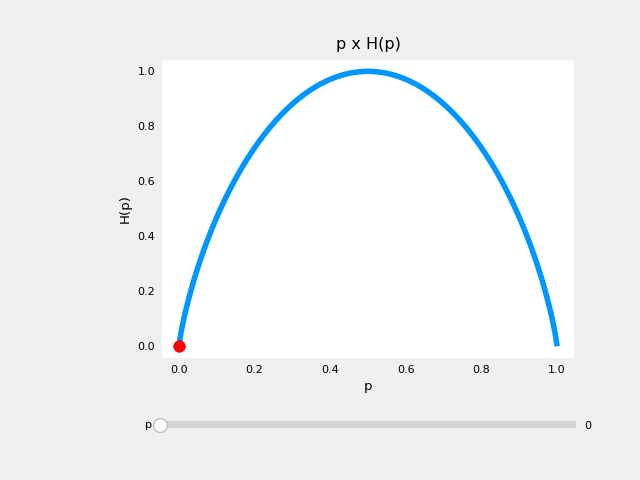

In [35]:
%matplotlib widget
_ = plot_entropy()

|                                                     |   Ear Shape | Face Shape | Whiskers |   Cat  |
|:---------------------------------------------------:|:---------:|:-----------:|:---------:|:------:|
| <img src="images/0.png" alt="drawing" width="50"/> |   Pointy   |   Round     |  Present  |    1   |
| <img src="images/1.png" alt="drawing" width="50"/> |   Floppy   |  Not Round  |  Present  |    1   |
| <img src="images/2.png" alt="drawing" width="50"/> |   Floppy   |  Round      |  Absent   |    0   |
| <img src="images/3.png" alt="drawing" width="50"/> |   Pointy   |  Not Round  |  Present  |    0   |
| <img src="images/4.png" alt="drawing" width="50"/> |   Pointy   |   Round     |  Present  |    1   |
| <img src="images/5.png" alt="drawing" width="50"/> |   Pointy   |   Round     |  Absent   |    1   |
| <img src="images/6.png" alt="drawing" width="50"/> |   Floppy   |  Not Round  |  Absent   |    0   |
| <img src="images/7.png" alt="drawing" width="50"/> |   Pointy   |  Round      |  Absent   |    1   |
| <img src="images/8.png" alt="drawing" width="50"/> |    Floppy  |   Round     |  Absent   |    0   |
| <img src="images/9.png" alt="drawing" width="50"/> |   Floppy   |  Round      |  Absent   |    0   |


We will use **one-hot encoding** to encode the categorical features. They will be as follows:

- Ear Shape: Pointy = 1, Floppy = 0
- Face Shape: Round = 1, Not Round = 0
- Whiskers: Present = 1, Absent = 0

Therefore, we have two sets:

- `X_train`: for each example, contains 3 features:
            - Ear Shape (1 if pointy, 0 otherwise)
            - Face Shape (1 if round, 0 otherwise)
            - Whiskers (1 if present, 0 otherwise)
            
- `y_train`: whether the animal is a cat
            - 1 if the animal is a cat
            - 0 otherwise

In [36]:
X_train = np.array([[1, 1, 1],
[0, 0, 1],
 [0, 1, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 1, 0],
 [0, 1, 0]])

y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [37]:
#For instance, the first example
X_train[0]

array([1, 1, 1])

This means that the first example has a pointy ear shape, round face shape and it has whiskers.

On each node, we compute the information gain for each feature, then split the node on the feature with the higher information gain, by comparing the entropy of the node with the weighted entropy in the two splitted nodes. 

So, the root node has every animal in our dataset. Remember that $p_1^{node}$ is the proportion of positive class (cats) in the root node. So

$$p_1^{node} = \frac{5}{10} = 0.5$$

Now let's write a function to compute the entropy.

In [38]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    
print(entropy(0.5))

1.0


To illustrate, let's compute the information gain if we split the node for each of the features. To do this, let's write some functions.

In [39]:
def split_indices(X, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have 
    that feature = 1 and the right node those that have the feature = 0 
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

So, if we choose Ear Shape to split, then we must have in the left node (check the table above) the indices:

$$0 \quad 3 \quad 4 \quad 5 \quad 7$$

and the right indices, the remaining ones.

In [40]:
split_indices(X_train, 0)

([0, 3, 4, 5, 7], [1, 2, 6, 8, 9])

Now we need another function to compute the weighted entropy in the splitted nodes. As you've seen in the video lecture, we must find:

- $w^{\text{left}}$ and $w^{\text{right}}$, the proportion of animals in **each node**.
- $p^{\text{left}}$ and $p^{\text{right}}$, the proportion of cats in **each split**.

Note the difference between these two definitions!! To illustrate, if we split the root node on the feature of index 0 (Ear Shape), then in the left node, the one that has the animals 0, 3, 4, 5 and 7, we have:

$$w^{\text{left}}= \frac{5}{10} = 0.5 \text{ and } p^{\text{left}} = \frac{4}{5}$$
$$w^{\text{right}}= \frac{5}{10} = 0.5 \text{ and } p^{\text{right}} = \frac{1}{5}$$

In [41]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    p_right = sum(y[right_indices])/len(right_indices)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

In [42]:
left_indices, right_indices = split_indices(X_train, 0)
weighted_entropy(X_train, y_train, left_indices, right_indices)

0.7219280948873623

So, the weighted entropy in the 2 split nodes is 0.72. To compute the **Information Gain** we must subtract it from the entropy in the node we chose to split (in this case, the root node). 

In [43]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

In [44]:
information_gain(X_train, y_train, left_indices, right_indices)

0.2780719051126377

In [45]:
for i, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, i)
    i_gain = information_gain(X_train, y_train, left_indices, right_indices)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")
    

Feature: Ear Shape, information gain if we split the root node using this feature: 0.28
Feature: Face Shape, information gain if we split the root node using this feature: 0.03
Feature: Whiskers, information gain if we split the root node using this feature: 0.12


So, the best feature to split is indeed the Ear Shape. Run the code below to see the split in action. You do not need to understand the following code block. 

In [46]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=1, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

 Depth 0, Root: Split on feature: 0
 - Left leaf node with indices [0, 3, 4, 5, 7]
 - Right leaf node with indices [1, 2, 6, 8, 9]


FileNotFoundError: [Errno 2] "dot" not found in path.

The process is **recursive**, which means we must perform these calculations for each node until we meet a stopping criteria:

- If the tree depth after splitting exceeds a threshold
- If the resulting node has only 1 class
- If the information gain of splitting is below a threshold

The final tree looks like this:

In [47]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=2, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

 Depth 0, Root: Split on feature: 0
- Depth 1, Left: Split on feature: 1
  -- Left leaf node with indices [0, 4, 5, 7]
  -- Right leaf node with indices [3]
- Depth 1, Right: Split on feature: 2
  -- Left leaf node with indices [1]
  -- Right leaf node with indices [2, 6, 8, 9]


FileNotFoundError: [Errno 2] "dot" not found in path.

Congratulations! You completed the notebook!